In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

cookie_data = pd.read_csv('cookie_cats.csv')

In [35]:
# Прверяем исходные данные
cookie_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Чистим датафрейм от ненужных пользователей

In [36]:
# Проверяем пользователей (userid) на уникальность, чтобы не было пересечений

if cookie_data.userid.nunique() - len(cookie_data) == 0:
    print('All the users are unique')

All the users are unique


In [37]:
# Рассмотрим количество пользователей, ни разу не игравших в игру. Также найдем какой это процент от общего числа

print('Number of players never played this game: ', cookie_data[cookie_data.sum_gamerounds == 0].userid.count(),
      '\nThe percentage of the total: ', round(cookie_data[cookie_data.sum_gamerounds == 0].userid.count()/len(cookie_data) * 100, 2))

Number of players never played this game:  3994 
The percentage of the total:  4.43


In [38]:
# При запуске игры, она предлагает сыграть сразу в первые 2 раунда, потом уже появляется возможность выйти в главный экран
# или посмотреть карту, количество уровней и т.п.
# Так как мы проверяем влияние эксперимента, который заключается в изменении gate_30 на gate_40 (ворота переместились с 30
# на 40 уровень), следовательно, игрок должен сыграть, как минимум, 1-2 раунда. Уберем пользователей, не сыгравших ни разу.

cookie_data.drop(np.where(cookie_data.sum_gamerounds == 0)[0], inplace=True)

# АБ тест

In [39]:
# Делим данные на 2 группы для определения статзначимости изменений для разнызх метрик

group_30 = cookie_data[cookie_data.version == 'gate_30'].reset_index(drop=True)
group_40 = cookie_data[cookie_data.version == 'gate_40'].reset_index(drop=True)

data = {'userid': [group_30.userid.count(), group_40.userid.count()], 
        'sum_gamerounds': [group_30.sum_gamerounds.sum(), group_40.sum_gamerounds.sum()], 
        'retention_1': [group_30.retention_1.mean(), group_40.retention_1.mean()], 
        'retention_7': [group_30.retention_7.mean(), group_40.retention_7.mean()]}
df = pd.DataFrame(data, index=['group_30', 'group_40'])
df

# Как видно из таблицы, оценить изменение "на глазок" не получится, поэтому воспользуемся стат. критериями

,userid,sum_gamerounds,retention_1,retention_7
group_30,42763,2344795,0.467530,0.198443
group_40,43432,2333530,0.462171,0.190321


In [40]:
# Блок с объявлением функций, которые будут использоваться дальше

alpha = 0.05

def histograms(series_1, series_2, b=10):
    series_1.hist(alpha=0.4, weights=[1/len(series_1)]*len(series_1), bins=b, color='red')
    series_2.hist(alpha=0.4, weights=[1/len(series_2)]*len(series_2), bins=b, color='green')
    plt.axvline(series_1.mean(), color='red', alpha=1, linestyle='dashed')
    plt.axvline(series_2.mean(), color='green', alpha=1, linestyle='dashed')
    
def leven_test(series_1, series_2):
    st_var = levene(series_1, series_2)
    print('Variances of distributions is {}equal\n'.format({True:'not ', False:''}[st_var[1] < alpha]))

### Рассмотрим метрику sum_gamerounds

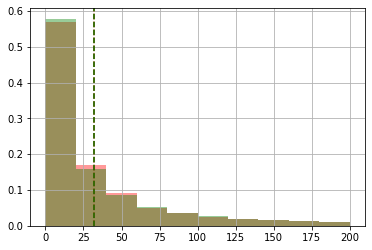

In [22]:
# Визуализируем распределения в группах. Для более удобного восприятия рассмотрим пользователей, которые сыграли 
# менее 200 раундов, так как уже на этот момент будет понятен характер распределения.

series_group_30 = group_30.drop(np.where(group_30.sum_gamerounds > 200)[0]).sum_gamerounds
series_group_40 = group_40.drop(np.where(group_40.sum_gamerounds > 200)[0]).sum_gamerounds

histograms(series_group_30, series_group_40, b=10)

In [23]:
# Проведем дисперсионный анализ

leven_test(group_30.sum_gamerounds, group_40.sum_gamerounds)

Variances of distributions is equal



In [24]:
# Для оценки статзначимости воспользуемся методом bootstrap_ab.

bs_ab_estims = bs.bootstrap_ab(group_30.sum_gamerounds.values, 
                               group_40.sum_gamerounds.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=10000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

2.256366632607224    (-3.639548266010233, 6.460119212287354)

In [25]:
# Как мы можем заметить, доверительный итервал, который является результатом bootstrap_ab, содержит 0, следовательно,
# изменения не значительны.

if bs_ab_estims.lower_bound < 0 and bs_ab_estims.upper_bound > 0:
    print('Diffs is not significant')
else: print('Diffs is significant')

Diffs is not significant


In [26]:
# Значит, что изменения никак не повлияли на количество раундов, сыгранных игроками.

### Рассмотрим метрику retention_1

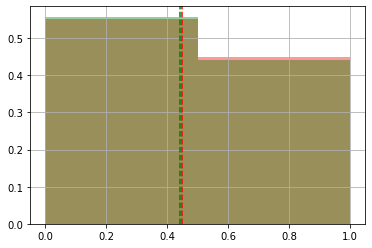

In [27]:
# Визуализируем распределения в группах

series_group_30 = group_30.retention_1.apply(lambda x: 1 if x == True else 0)
series_group_40 = group_40.retention_1.apply(lambda x: 1 if x == True else 0)

histograms(series_group_30, series_group_40, b=2)

In [28]:
# Для оценки статзначимости воспользуемся методом bootstrap_ab.

bs_ab_estims = bs.bootstrap_ab(group_30.retention_1.values, 
                               group_40.retention_1.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=10000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

1.3351571571965584    (-0.1536780299144156, 2.7958866915351392)

In [29]:
# Как мы можем заметить, доверительный итервал, который является результатом bootstrap_ab, содержит 0, следовательно,
# изменения не значительны. 

if bs_ab_estims.lower_bound < 0 and bs_ab_estims.upper_bound > 0:
    print('Diffs is not significant')
else: print('Diffs is significant')

Diffs is not significant


In [30]:
# Значит, что изменения никак не повлияли на то, зашел ли игрок спустя 1 день в игру.

### Рассмотрим метрику retention_7

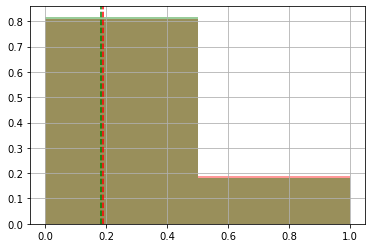

In [31]:
# Визуализируем распределения в группах

series_group_30 = group_30.retention_7.apply(lambda x: 1 if x == True else 0)
series_group_40 = group_40.retention_7.apply(lambda x: 1 if x == True else 0)

histograms(series_group_30, series_group_40, b=2)

In [32]:
# Для оценки статзначимости воспользуемся методом bootstrap_ab.

bs_ab_estims = bs.bootstrap_ab(group_30.retention_7.values, 
                               group_40.retention_7.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=10000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

4.506206776910276    (1.6659375993586831, 7.295966076313835)

In [33]:
# Как мы можем заметить, доверительный итервал, который является результатом bootstrap_ab, не содержит 0, следовательно,
# изменения значительны.

if bs_ab_estims.lower_bound < 0 and bs_ab_estims.upper_bound > 0:
    print('Diffs is not significant')
else: print('Diffs is significant')

Diffs is significant


In [17]:
# Значит, что из-за изменений уменьшилось количество пользователей (по первому результату метода), которые вернулись
# спустя 7 дней.

Таким образом можно сказать, что изменения повлияли негативно на игру, так как 7-дневное удержание стало меньше. Поэтому, если мы хотим сохранить высокий уровень удержания как 1-дневный, мы не должны перемещать ворота с уровня 30 на уровень 40, так как такая метрика, как удержание игроков является одной из самых важных. Однако, чтоб сделать окончательный вывод, можно было бы рассмотреть и иные метрики, например, количество внутриигровых покупок, просмотр рекламы и т.п. Но в наших изначальных данных такие метрики не рассматривались. 